# Homework: classify the origin of names using a character-level RNN

In this homework we will use an rnn-based model to perform classification. The goal is threefold:

1. Get more hands on with the preprocessing needed to perform text classification from A to Z. No preprocessing is done for you!
2. Use embeddings and RNNs in conjunction at the character level to perform classification.
3. Write a function that takes as input a string, and outputs the name of the predicted class.

However, here are guidelines to help you through all the steps:

1. Figure out the number of classes, and map the classes to integers (or one-hot vectors). This is needed for fitting the model and training it to do classification.
2. Use the keras tokenizer at the character level to tokenize your input into integer sequences.
3. Pad your sequences using the keras preprocessing tools.
4. Build a model that uses, minimally, an embedding layer, an RNN (of your choice) and a dense layer to output the logits or probabilities for the target classes (name origins).
5. Fit the model and evaluate on the test set.
6. Write a function that takes a string as input and predicts the origin (as its original string value)

In [4]:
%tensorflow_version 2.x
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [1]:
# Download the data
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-05-29 14:49:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.50.98, 13.226.50.24, 13.226.50.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.50.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2021-05-29 14:49:33 (21.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [109]:
data = []
for filename in glob('data/names/*.txt'):
  origin = filename.split('/')[-1].split('.txt')[0]
  names = open(filename).readlines()
  for name in names:
    data.append((name.strip(), origin))

names, origins = zip(*data)
names_train, names_test, origins_train, origins_test = train_test_split(names, origins, test_size=0.25, shuffle=True, random_state=123)

# Look at the data

In [269]:
for name, origin in zip(names_train[:20], origins_train[:20]):
  print(name.ljust(20), origin)

Jokin                Russian
Pellegrino           Italian
Taidhg               Irish
Habelashvili         Russian
Makhorin             Russian
Charnock             English
Shamoun              Arabic
Juravsky             Russian
Inihara              Japanese
Schetchikov          Russian
Tsenin               Russian
Shahurin             Russian
Shammas              Arabic
Cuocco               Italian
Nasato               Italian
Edney                English
Macpherson           English
Abulmambetov         Russian
Weaver               English
Farrell              Irish


In [275]:
type(names_train[0])

str

In [276]:
import pandas as pd
train = pd.DataFrame({'names':names_train, 'origins':origins_train})
test = pd.DataFrame({'names':names_test, 'origins':origins_test})
test.head()


,names,origins
0,Vallakh,Russian
1,Jin,Chinese
2,Rosario,Portuguese
3,Krawiec,Czech
4,Davydchenko,Russian


In [112]:
test.shape

(5019, 2)

In [114]:
np.unique(origins)

array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
       'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
       'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish',
       'Vietnamese'], dtype='<U10')

In [314]:
class_names = ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
       'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
       'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish',
       'Vietnamese']

In [116]:
len(class_names)

18

In [277]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# integer encode
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(origins_train)
integer_encoded_test = label_encoder.fit_transform(origins_test)

print(integer_encoded_train)
print(integer_encoded_test)

# binary encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)

[14  9  8 ...  6  0  7]
[14  1 13 ... 14 14 14]


In [278]:
import tensorflow as tf
from tensorflow import keras

In [279]:
# Tokenize our training data
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(names_train)

In [297]:
print(tokenizer.texts_to_sequences(names_train))

[[23, 2, 9, 4, 5], [22, 3, 10, 10, 3, 18, 6, 4, 5, 2], [12, 1, 4, 15, 8, 18], [8, 1, 16, 3, 10, 1, 7, 8, 11, 4, 10, 4], [14, 1, 9, 8, 2, 6, 4, 5], [19, 8, 1, 6, 5, 2, 19, 9], [7, 8, 1, 14, 2, 13, 5], [23, 13, 6, 1, 11, 7, 9, 17], [4, 5, 4, 8, 1, 6, 1], [7, 19, 8, 3, 12, 19, 8, 4, 9, 2, 11], [12, 7, 3, 5, 4, 5], [7, 8, 1, 8, 13, 6, 4, 5], [7, 8, 1, 14, 14, 1, 7], [19, 13, 2, 19, 19, 2], [5, 1, 7, 1, 12, 2], [3, 15, 5, 3, 17], [14, 1, 19, 22, 8, 3, 6, 7, 2, 5], [1, 16, 13, 10, 14, 1, 14, 16, 3, 12, 2, 11], [24, 3, 1, 11, 3, 6], [21, 1, 6, 6, 3, 10, 10], [22, 1, 6, 1, 15, 20, 4, 5, 7, 9, 17], [11, 3, 15, 4, 9, 8, 2, 11], [19, 8, 1, 18, 1, 5, 2, 11], [14, 1, 6, 4, 1, 5, 4], [20, 8, 15, 1, 9, 1, 3, 11], [16, 10, 1, 20, 3, 23, 2, 11, 7, 9, 17], [17, 2, 13], [4, 7, 1], [18, 2, 5, 20, 1, 10, 3, 20], [3, 10, 10, 24, 2, 2, 15], [22, 3, 6, 3, 4, 6, 1], [5, 3, 11, 3, 20, 8, 4, 5], [18, 10, 13, 20, 14, 1, 5], [11, 1, 5, 9, 3], [14, 2, 7, 8, 9, 4, 5], [5, 3, 13, 7, 7, 3, 6], [1, 6, 14, 3, 6], [11, 1

In [298]:
print(tokenizer.sequences_to_texts([[23, 2, 9, 4, 5]]))
print(tokenizer.sequences_to_texts([[22, 3, 10, 10, 3, 18, 6, 4, 5, 2]]))

['j o k i n']
['p e l l e g r i n o']


In [299]:
# Get our training data word index
word_index = tokenizer.word_index
print(word_index)

{'a': 1, 'o': 2, 'e': 3, 'i': 4, 'n': 5, 'r': 6, 's': 7, 'h': 8, 'k': 9, 'l': 10, 'v': 11, 't': 12, 'u': 13, 'm': 14, 'd': 15, 'b': 16, 'y': 17, 'g': 18, 'c': 19, 'z': 20, 'f': 21, 'p': 22, 'j': 23, 'w': 24, ' ': 25, 'q': 26, "'": 27, 'x': 28, 'ö': 29, '-': 30, 'é': 31, 'í': 32, 'á': 33, 'ä': 34, 'ü': 35, 'ó': 36, 'ß': 37, 'à': 38, 'ú': 39, 'ñ': 40, '1': 41, ',': 42, 'ś': 43, 'ò': 44, 'ê': 45, 'è': 46, 'ù': 47, 'õ': 48, 'ì': 49, '\xa0': 50, 'ç': 51, 'ń': 52, 'ã': 53, 'ą': 54, 'ł': 55, 'ż': 56, '/': 57}


In [300]:
# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(names_train)
test_sequences = tokenizer.texts_to_sequences(names_test)

print(train_sequences[0])
print(test_sequences[0])

[23, 2, 9, 4, 5]
[11, 1, 10, 10, 1, 9, 8]


In [283]:
# Get max training sequence length
maxlen_train = max([len(x) for x in train_sequences])
maxlen_test = max([len(x) for x in test_sequences])
print(maxlen_train, maxlen_test)

20 17


In [284]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_type = 'post'
trunc_type = 'post'

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_train)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_train)

In [285]:
train_padded

array([[23,  2,  9, ...,  0,  0,  0],
       [22,  3, 10, ...,  0,  0,  0],
       [12,  1,  4, ...,  0,  0,  0],
       ...,
       [ 7,  4,  3, ...,  0,  0,  0],
       [16,  1,  0, ...,  0,  0,  0],
       [ 7,  1, 14, ...,  0,  0,  0]], dtype=int32)

In [286]:
test_padded

array([[11,  1, 10, ...,  0,  0,  0],
       [23,  4,  5, ...,  0,  0,  0],
       [ 6,  2,  7, ...,  0,  0,  0],
       ...,
       [20,  2, 10, ...,  0,  0,  0],
       [22,  1, 20, ...,  0,  0,  0],
       [23, 13, 20, ...,  0,  0,  0]], dtype=int32)

In [166]:
train_padded.shape

(15055, 20)

In [168]:
embedding_input_dim = len(tokenizer.word_index)+1 # number of distinct characters
embedding_output_dim = 32

print(embedding_input_dim)

58


In [151]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
import keras.backend as K

K.clear_session()

model = Sequential()
model.add(Embedding(input_dim=embedding_input_dim,
                            output_dim=embedding_output_dim,
                            mask_zero=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(18))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [152]:
h = model.fit(train_padded, integer_encoded_train,batch_size=32,epochs=30, validation_split=0.2)

Epoch 1/30
377/377 [==============================] - 37s 78ms/step - loss: 1.8653 - accuracy: 0.4819 - val_loss: 1.3716 - val_accuracy: 0.6051
Epoch 2/30
377/377 [==============================] - 26s 69ms/step - loss: 1.2887 - accuracy: 0.6269 - val_loss: 1.2413 - val_accuracy: 0.6277
Epoch 3/30
377/377 [==============================] - 27s 70ms/step - loss: 1.1674 - accuracy: 0.6548 - val_loss: 1.0606 - val_accuracy: 0.6742
Epoch 4/30
377/377 [==============================] - 26s 69ms/step - loss: 1.0414 - accuracy: 0.6851 - val_loss: 0.9773 - val_accuracy: 0.6998
Epoch 5/30
377/377 [==============================] - 26s 70ms/step - loss: 0.9457 - accuracy: 0.7124 - val_loss: 0.9060 - val_accuracy: 0.7180
Epoch 6/30
377/377 [==============================] - 26s 70ms/step - loss: 0.8617 - accuracy: 0.7408 - val_loss: 0.8617 - val_accuracy: 0.7370
Epoch 7/30
377/377 [==============================] - 26s 70ms/step - loss: 0.7986 - accuracy: 0.7552 - val_loss: 0.8086 - val_accuracy:

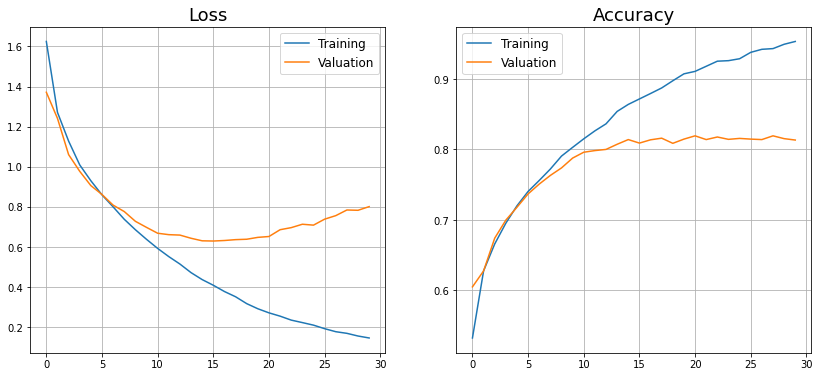

In [154]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].plot(h.history['loss'], label='Training')
axs[0].plot(h.history['val_loss'], label='Valuation')
axs[0].set_title('Loss', fontsize=18)
axs[0].grid(True)
axs[0].legend(fontsize=12)

axs[1].plot(h.history['accuracy'], label='Training')
axs[1].plot(h.history['val_accuracy'], label='Valuation')
axs[1].set_title('Accuracy', fontsize=18)
axs[1].grid(True)
axs[1].legend(fontsize=12)

In [169]:
# Evaluate the model on the test data 
print("Evaluate on test data")
results = model.evaluate(test_padded, integer_encoded_test, batch_size=32)
print("Test Loss, Test Accuracy:", results)

Evaluate on test data
157/157 [==============================] - 6s 20ms/step - loss: 0.7522 - accuracy: 0.8203
Test Loss, Test Accuracy: [0.7522135376930237, 0.8202829360961914]


In [336]:
def predict_origin(name):
  assert isinstance(name, str)
  
  # do something with the model
  sequences = tokenizer.texts_to_sequences([name])
  padded = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_train)
  y_pred = np.argmax(model.predict(padded), axis=-1)

  # do something with model output
  the_origin = class_names[y_pred[0]]

  return the_origin

In [348]:
predict_origin('Marie')

'French'